In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
ROOT_PATH = "/content/drive/MyDrive/speed-prediction/"
print(os.listdir(ROOT_PATH))

In [3]:
import sys
sys.path.append(ROOT_PATH)

In [ ]:
requirements = ROOT_PATH + "/requirements.txt"
%pip install -r {requirements}

In [16]:
import cv2
import os
import time
import numpy as np
import h5py
import os, random
import matplotlib.pylab as plt
import keras.utils.vis_utils as vutil
from skimage.transform import resize
from IPython.display import SVG
import tensorflow as tf
import keras.models as models
from imgaug import augmenters as iaa
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import MaxPooling2D, UpSampling2D, Conv2D, Conv2DTranspose, ZeroPadding2D, Conv3D, MaxPooling3D, ZeroPadding3D
from keras.layers import BatchNormalization, GlobalAveragePooling2D, GlobalAveragePooling3D, Add
from keras.utils import np_utils
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Lambda, add, LSTM, GRU, TimeDistributed, concatenate
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.utils import conv_utils
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import InputSpec
from tensorflow.keras.optimizers import SGD, Adam, AdamW, RMSprop
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.vgg16 import preprocess_input
import matplotlib.animation as animation
import sys
from PIL import Image
from IPython.display import Image

%matplotlib inline

In [6]:
def show(image, cmap='gray', ax=None):
    if ax is None:
        plt.figure()
    
    plt.imshow(image[:,:,::-1].astype('uint8'), cmap=cmap)

In [7]:
FRAME_H, FRAME_W = 112, 112
TIMESTEPS = 16

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Code up the generators

A short snippet to create training set and validation set from the given video data.

In [ ]:
""" Creating image with labels from video on own computer (ANACONDA) """
"""label_inp = open(ROOT_PATH + 'labels.txt').readlines()

video_reader = cv2.VideoCapture(ROOT_PATH + 'data/train.mp4')
train_image = ROOT_PATH + 'images/'
train_label = open(ROOT_PATH + 'data/labels.txt', 'w')

counter = 0

while(True):
    ret, frame = video_reader.read() 

    if ret == True:
        cv2.imwrite(train_image + str(counter).zfill(6) + '.png', frame) 
        train_label.write(label_inp[counter]) 
        counter += 1
    else:
        break

video_reader.release()
train_label.close()
"""


These are a set of functions to add disturtances to the images used during the training process.

In [ ]:
sometime = lambda aug: iaa.Sometimes(0.3, aug) #randomly apply some of the augmentations with a prob of 0.3
sequence = iaa.Sequential([ #sometime(iaa.GaussianBlur((0, 1.5))), # blur images with a sigma between 0 and 3.0
                            #sometime(iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5))), # sharpen images
                            #sometime(iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 3.), per_channel=0.5)), # add gaussian noise to images
                            #sometime(iaa.Dropout((0.0, 0.1))), # randomly remove up to 10% of the pixels
                            #sometime(iaa.CoarseDropout((0.0, 0.1), size_percent=(0.01, 0.02), per_channel=0.2)),
                            #sometime(iaa.Add((-10, 10), per_channel=0.5)), # change brightness of images (by -10 to 10 of original value)
                          ],
                          random_order=True # do all of the above in random order
                         )

def normalize(image):
    return image - [104.00699, 116.66877, 122.67892] #image - [mean pixel values]

def augment(image, flip, bright_factor):
    # random disturbances borrowed from IAA
    image = sequence.augment_image(image)
    
    # random brightness change
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV) 
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor 
    image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB) 
    
    # random flip (vertical axis)
    if flip:
        image = cv2.flip(image, 1) 
                
    return image

This is the class to generate batches for both training and validation.

In [ ]:
class BatchGenerator:
    def __init__(self, indices, batch_size, timesteps=1, shuffle=True, jitter = True, norm=True, overlap=False):
        #self.file_path  = file_path
        self.batch_size = batch_size
        self.timesteps  = timesteps
        
        self.shuffle = shuffle
        self.jitter  = jitter
        self.norm    = norm

        self.images = sorted(os.listdir(ROOT_PATH + 'images/'))
        self.labels = open(ROOT_PATH + 'data/labels.txt').readlines()
        
        self.indices = indices

    def get_gen(self):
        num_img = len(self.indices)
        
        l_bound = 0
        r_bound = self.batch_size if self.batch_size < num_img else num_img    
        
        if self.shuffle: np.random.shuffle(list(self.indices))# Convert range object to list

        while True:
            if l_bound == r_bound:
                l_bound = 0
                r_bound = self.batch_size if self.batch_size < num_img else num_img
                
                if self.shuffle: np.random.shuffle(list(self.indices))

            # the arrays which hold in the inputs and outputs
            x_batch = np.zeros((r_bound - l_bound, self.timesteps, FRAME_H, FRAME_W, 3))
            y_batch = np.zeros((r_bound - l_bound, 1))
            currt_inst = 0        

            for index in self.indices[l_bound:r_bound]:
                #if index > 2*self.timesteps:
                #    index -= np.random.randint(0, self.timesteps)
                
                # construct each input
                flip = (np.random.random() > 0.5)
                bright_factor = 0.5 + np.random.uniform() * 0.5
                
                for i in range(self.timesteps):
                    image = cv2.imread(ROOT_PATH + 'images/' + self.images[index-self.timesteps+1+i])
                    heigh = image.shape[0]
                    image = image[np.concatenate([np.arange(int(heigh/3)), np.arange(int(heigh*2/3),heigh)]),:,:]
                    image = cv2.resize(image.copy(), (FRAME_H, FRAME_W))
                    
                    if self.jitter: image = augment(image, flip, bright_factor)
                    if self.norm:   image = normalize(image)                    
                    
                    x_batch[currt_inst, i] = image

                # construct each output
                speeds = [float(speed) for speed in self.labels[index-self.timesteps+1:index+1]]
                y_batch[currt_inst] = np.mean(speeds)

                currt_inst += 1
                
            yield x_batch, y_batch

            l_bound = r_bound
            r_bound = r_bound + self.batch_size
            if r_bound > num_img: r_bound = num_img
                
    def get_size(self):
        return len(self.indices)/self.batch_size 

Perform some visualization to make sure that the generated batches make sense.

In [ ]:
indices = range(TIMESTEPS-1, len(os.listdir(ROOT_PATH + 'images/')), TIMESTEPS)
gen_train = BatchGenerator(indices, batch_size=4, timesteps=TIMESTEPS)
generator = gen_train.get_gen()

In [ ]:
len(os.listdir(ROOT_PATH + 'images/')) # number of images 

20400

In [ ]:
gen_train.get_size()

318.75

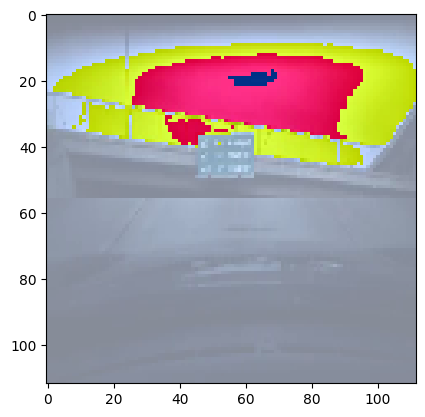

In [ ]:
show(next(generator)[0][0][0])

# Construct the model

We use 3D CNNs as our final model. The structure of 3D CNN as follows.

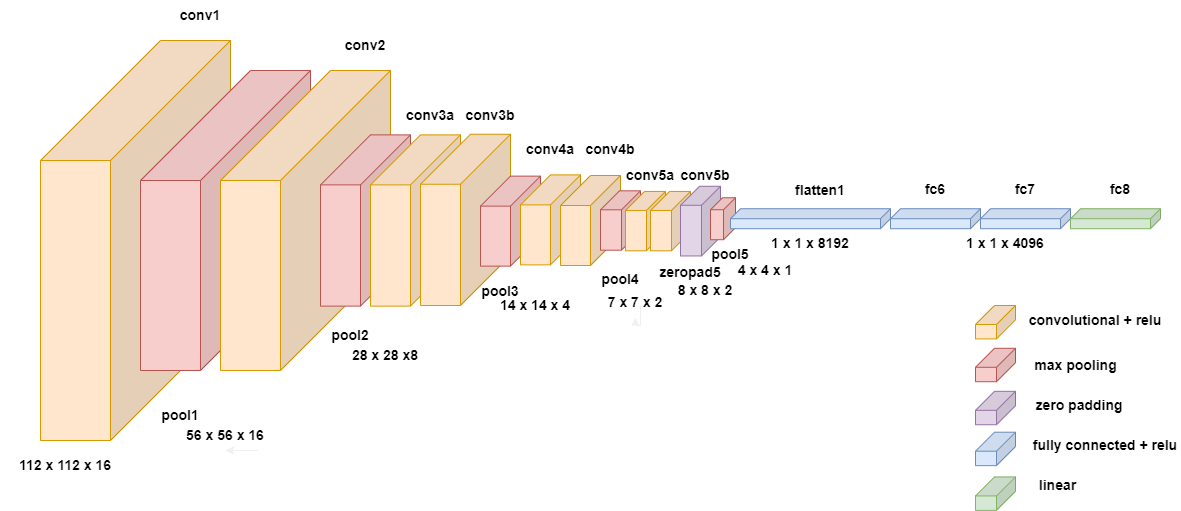

In [18]:
# show our best model
CNN_image_path = ROOT_PATH + "/3D_CNN.png"

Image(filename=CNN_image_path)

In [ ]:
def createModel(insert_network=None):
  """Input: 'lstm' or 'gru' or empty (default value is None)
     Output: original model with lstm or original model with gru, original model (default)
  """

  model = Sequential()
  input_shape=(TIMESTEPS, FRAME_H, FRAME_W, 3) # l, h, w, c

  # 1st layer group
  model.add(Conv3D(64, (3, 3, 3),  activation='relu', padding='same', name='conv1', input_shape=input_shape)) 
  model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), padding='valid', name='pool1')) 

  # 2nd layer group
  model.add(Conv3D(128, (3, 3, 3), activation='relu', padding='same', name='conv2'))
  model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool2'))

  # 3rd layer group
  model.add(Conv3D(256, (3, 3, 3), activation='relu', padding='same', name='conv3a'))
  model.add(Conv3D(256, (3, 3, 3), activation='relu', padding='same', name='conv3b'))
  model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool3'))

  # 4th layer group
  model.add(Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv4a'))
  model.add(Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv4b'))
  model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool4'))

  # 5th layer group
  model.add(Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv5a'))
  model.add(Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv5b'))
  model.add(ZeroPadding3D(padding=((0, 0), (0, 1), (0, 1)), name='zeropad5'))
  model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool5'))

  # add RNN
  if insert_network == "lstm":
    # add LSTM layer
    model.add(TimeDistributed(Flatten(), input_shape=(TIMESTEPS, FRAME_H // 2, FRAME_W // 2, 512), name='timedis1'))
    model.add(LSTM(128, return_sequences=True, name='lstm'))
    model.add(TimeDistributed(Dense(128, activation='relu'), name='dense1'))
    print("original model plus lmst layer")

  elif insert_network == 'gru':
    # add GRU layer
    model.add(TimeDistributed(Flatten(), input_shape=(TIMESTEPS, FRAME_H // 2, FRAME_W // 2, 512), name='timedis1'))
    model.add(GRU(128, return_sequences=True, name='gru'))
    model.add(TimeDistributed(Dense(128, activation='relu'), name='dense1'))
    print("original model plus gru layer")

  else:
    print("use orirginal model")

  model.add(Flatten())
  
  # FC layers group
  model.add(Dense(4096, activation='relu', name='fc6')) # 4096 <- 8192 // 2 
  model.add(Dropout(.5))
  model.add(Dense(4096, activation='relu', name='fc7'))
  model.add(Dropout(.5))
  model.add(Dense(1, activation='linear', name='fc8'))

  return model


We trained a resnet18 from scratch, but the output of model was overfitting.

In [ ]:
# Create a resnet block

def resnetBlock(x, filters, strides=(1, 1, 1), blockname=''):
    x_0 = x # x_0: initial state of x
    x = Conv3D(filters[0], (3, 3, 3), strides=strides, padding='same', name=blockname + '_conv1')(x)
    x = BatchNormalization(name=blockname + '_bn1')(x)
    x = Activation('relu', name=blockname + '_fc1')(x)
    x = Conv3D(filters[1], (3, 3, 3), padding='same', name=blockname + '_conv2')(x)
    x = BatchNormalization(name=blockname + '_bn2')(x)
  
    if strides != (1, 1, 1) or x_0.shape[4] != filters[1]:
        x = Conv3D(filters[1], (1, 1, 1), strides=strides, padding='valid', name=blockname + '_down_samp_conv1')(x_0)
        x = BatchNormalization(name=blockname + '_down_samp_bn1')(x_0)
  
    x = Add(name=blockname + '_add')([x, x_0])
    x = Activation('relu', name=blockname + '_fc2')(x)
  
    return x

In [ ]:
# Create a reset18 model

def renset18():
    input_tensor = Input(shape=(TIMESTEPS, FRAME_H, FRAME_W, 3))
  
    # Step 1
    x = Conv3D(64, (7, 7, 7), strides=(2, 2, 2), padding='same', name='conv1')(input_tensor)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu', name='fc1')(x)
    x = MaxPooling3D((1, 3, 3), strides=(1, 2, 2), padding='same', name='pool1')(x)
  
    # Step 2
    x = resnetBlock(x, filters=[64, 64], strides=(1, 1, 1), blockname='resnetblock1a')
    x = resnetBlock(x, filters=[64, 64], blockname='resnetblock1b')
  
    # Step 3
    x = resnetBlock(x, filters=[128, 128], strides=(2, 2, 2), blockname='resnetblock2a')
    x = resnetBlock(x, filters=[128, 128], blockname='resnetblock2b')
  
    # Step 4
    x = resnetBlock(x, filters=[256, 256], strides=(2, 2, 2), blockname='resnetblock3a')
    x = resnetBlock(x, filters=[256, 256], blockname='resnetblock3b')
  
    # Step 5
    x = resnetBlock(x, filters=[512, 512], strides=(2, 2, 2), blockname='resnetblock4a')
    x = resnetBlock(x, filters=[512, 512], blockname='resnetblock4b')
  
    x = GlobalAveragePooling3D(name='pool2')(x)
    x = Dense(1, activation='linear', name='fc2')(x)
  
    model = Model(inputs=input_tensor, outputs=x)
  
    return model

In [ ]:
resnet18_model = renset18()

In [ ]:
resnet18_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 16, 112, 11  0           []                               
                                2, 3)]                                                            
                                                                                                  
 conv1 (Conv3D)                 (None, 8, 56, 56, 6  65920       ['input_11[0][0]']               
                                4)                                                                
                                                                                                  
 bn1 (BatchNormalization)       (None, 8, 56, 56, 6  256         ['conv1[0][0]']                  
                                4)                                                          

In [ ]:
model = createModel()
model_add_lstm = createModel('lstm')
model_add_gru = createModel('gru')

use orirginal model
original model plus lmst layer
original model plus gru layer


In [ ]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv3D)              (None, 16, 112, 112, 64)  5248      
                                                                 
 pool1 (MaxPooling3D)        (None, 16, 56, 56, 64)    0         
                                                                 
 conv2 (Conv3D)              (None, 16, 56, 56, 128)   221312    
                                                                 
 pool2 (MaxPooling3D)        (None, 8, 28, 28, 128)    0         
                                                                 
 conv3a (Conv3D)             (None, 8, 28, 28, 256)    884992    
                                                                 
 conv3b (Conv3D)             (None, 8, 28, 28, 256)    1769728   
                                                                 
 pool3 (MaxPooling3D)        (None, 4, 14, 14, 256)  

# Load weights pretrained on the Sports-1M dataset

In [ ]:
sports_1m = h5py.File(ROOT_PATH + 'data/c3d-sports1M_weights.h5', mode='r')

for i in range(len(model.layers)):
    layer = model.layers[i]
    layer_name = 'layer_' + str(i)
    
    weights = sports_1m[layer_name].values()
    weights = [np.array(weight) for weight in weights] 
    weights = [np.array(weight) if len(weight.shape) < 4 else np.transpose(weight, (2,3,4,1,0)) for weight in weights]

    layer.set_weights(weights)
    
    # ignore the last 2 layer, 1 dropout and 1 dense
    if i > len(model.layers) - 3:
        break

In [ ]:
for layer in model.layers:
    has_weights = False
    for weight in layer.weights:

        if weight.numpy().any() > 0:
            has_weights = True
            break

    if has_weights:
        print("yes")  # Print "yes" if the layer has weights
    else:
        print("no")  # Print "no" if the layer does not have weights


# Train the network

In [ ]:
early_stop  = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2, mode='min', verbose=1)
checkpoint  = ModelCheckpoint(ROOT_PATH + 'data/new_c3d-sports1M_weights.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_freq=1)

split_ratio = 0.90

indices = range(TIMESTEPS-1, len(os.listdir(ROOT_PATH + 'images/')), TIMESTEPS) 
np.random.shuffle(list(indices))

train_indices = list(indices[0:int(len(indices)*split_ratio)])
valid_indices = list(indices[int(len(indices)*split_ratio):])

gen_train = BatchGenerator( train_indices, batch_size=4, timesteps=TIMESTEPS)
gen_valid = BatchGenerator( valid_indices, batch_size=4, timesteps=TIMESTEPS, jitter = False)


In [ ]:
from keras.callbacks import LearningRateScheduler

# Define the learning rate schedule function
def lr_schedule(batch):
    # Calculate the desired learning rate based on the batch number
    learning_rate = 1e-4
    if batch > 50:
        learning_rate *= 0.5
    if batch > 100:
        learning_rate *= 0.2
    return learning_rate

# Create the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

In [ ]:
def custom_loss(y_true, y_pred):
    loss = tf.math.squared_difference(y_true, y_pred)
    loss = tf.reduce_mean(loss)
    
    return loss

In [ ]:
def train(model, epochs, model_save_path, optimizer):
  epochs = epochs
  best_val_loss = float('inf')
  best_weights_path = model_save_path  # Path to save the best model weights

  # Compile the model
  if optimizer == 'adam':
    adam = AdamW(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss=custom_loss, optimizer=adam)
  elif optimizer == 'sgd':
    sgd = SGD(lr=1e-5, decay=0.0005, momentum=0.9)
    model.compile(loss=custom_loss, optimizer=sgd)
  elif optimizer == 'rms':
    rms = RMSprop(lr=1e-3, rho=0.9, epsilon=1e-08, decay=0.0)
    model.compile(loss=custom_loss, optimizer=rms)

  for epoch in range(epochs):
      print(f"Epoch {epoch+1}/{epochs}")
      
      # Training
      model.fit_generator(generator=gen_train.get_gen(),
                          steps_per_epoch=gen_train.get_size(),
                          epochs=1,  # Train for 1 epoch
                          verbose=1,
                          callbacks = [early_stop, checkpoint, tensorboard],
                          max_queue_size = 8)
      
      # Validation
      val_loss = model.evaluate_generator(generator=gen_valid.get_gen(),
                                          steps=gen_valid.get_size(),
                                          verbose=1)
      print(f"Validation loss: {val_loss}")
      
      # Save best model
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          model.save_weights(best_weights_path)
          print("Best model saved!")

In [ ]:
tb_counter = max([int(num) for num in os.listdir(ROOT_PATH + 'logs/speed/') if num.isdigit()] or [0]) + 1
tensorboard = TensorBoard(log_dir=ROOT_PATH + 'logs/speed/' + str(tb_counter), histogram_freq=0, write_graph=True, write_images=False)

epochs = 15
best_weights_path = ROOT_PATH + 'logs/bestweightlsmt.h5'

train(model=resnet18_model,
      epochs=epochs, 
      model_save_path=best_weights_path, 
      optimizer='adam')


# Analyze the trained network

In [ ]:
file_name = 'train' # name without extension of arbitrary dashcam video

video_inp =  ROOT_PATH + 'logs/' + file_name + '.mp4'
video_out = ROOT_PATH + 'logs/' + file_name + '_out.mp4'
label_inp = open(ROOT_PATH + 'logs/' + file_name + '.txt', 'r').readlines() if os.path.exists(ROOT_PATH + 'logs/'+ file_name + '.txt') else None
label_out = open(ROOT_PATH + 'logs/' + file_name + '_pred.txt', 'w')

video_reader = cv2.VideoCapture(video_inp)
h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(video_out, fourcc, 20.0, (w, h))

x_batch_original = np.zeros((TIMESTEPS, h, w, 3))
x_batch = np.zeros((1, TIMESTEPS, FRAME_H, FRAME_W, 3))
frame_counter = 0
frame_counter_all = 0
curr_speed = 0.
acc_error = 0
import cv2


while(True):
    ret, image = video_reader.read()

    if ret == True:
        if frame_counter_all > -1: # only start processing from certain frame count
            x_batch_original[frame_counter] = image

            heigh = image.shape[0]
            image = image[np.concatenate([np.arange(int(heigh/3)), np.arange(int(heigh*2/3),heigh)]),:,:]
            image = cv2.resize(image.copy(), (FRAME_H, FRAME_W))
            image = normalize(image)

            x_batch[0, frame_counter] = image

            if frame_counter == TIMESTEPS - 1:

                curr_speed = model.predict(x_batch)[0][0]
                frame_counter = -1

                for i in range(TIMESTEPS):
                    image = x_batch_original[i]
                    caption = 'Speed (Predicted): ' + str("{0:.2f}".format(curr_speed))
                    image = cv2.putText(image, caption, (5,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 3)

                    # write true speed if available
                    if label_inp is not None:
                        true_speed = float(label_inp[frame_counter_all-(TIMESTEPS-1)+i].strip())
                        caption = 'Speed (Actual): ' + str("{0:.2f}".format(true_speed))
                        image = cv2.putText(image, caption, (5,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 3)
                        
                        acc_error += (curr_speed - true_speed) ** 2
                        caption = 'MSE: ' + str("{0:.2f}".format(acc_error/(frame_counter_all-TIMESTEPS+1+i+1)))
                        image = cv2.putText(image, caption, (5,150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 3)                        

                    video_writer.write(np.uint8(image))
                    label_out.write(str(curr_speed) + '\n')

            frame_counter += 1
    else:
        break
    
    frame_counter_all += 1

video_reader.release()
video_writer.release()

label_out.close()

# Test code

In [ ]:
video_out = 'test.mp4v'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video_writer = cv2.VideoWriter(video_out, fourcc, 20.0, (640, 480))

labels = open('test_pred.txt', 'w')

with open('inter.csv', 'r') as csvfile:
    print (csvfile.readline())
    
    for row in csvfile:
        if 'center' in row:
            row = row.split(',')

            image = cv2.imread(row[5])
            
            video_writer.write(np.uint8(image))
            #labels.write(row[8] + '\n')
            labels.write(str(float(row[8])*0.621371) + '\n')
            
video_writer.release()
labels.close()

In [ ]:
indices = range(16, len(os.listdir('images/')), 16)
np.random.shuffle(indices)

train_indices = indices[0:int(len(indices)*0.8)]
valid_indices = indices[int(len(indices)*0.8):]